# Speech Emotion Recognition and Machine Learning

In this project I build a prevision model using machine learning and more precisely **Support Vector Machine** to detect a person’s emotions just by their voice. 

### Audio features:
The complete list of the implemented short-term features is presented below:
- **Zero Crossing Rate**: The rate of sign-changes of the signal during the duration of a particular frame.
- **Energy**: The sum of squares of the signal values, normalized by the respective frame length.
- **Entropy of Energy**: The entropy of sub-frames' normalized energies. It can be interpreted as a measure of abrupt changes.
- **Spectral Centroid**: The center of gravity of the spectrum.
- **Sprectral Spread**: The second central moment of the spectrum.
- **Spectral Entropy**: Entropy of the normalized spectral energies for a set of sub-frames.
- **Spectral Flux**: The squared difference between the normalized magnitudes of the spectra of the two successive frames.
- **Spectral Rolloff**: The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
- **MFCCS**: Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

Global Statistics are then computed on upper features:
- **mean, std, med, kurt, skew, q1, q99, min, max and range**

### Data:
**RAVDESS**: The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) contains 7356 files (total size: 24.8 GB). The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes *calm*, *happy*, *sad*, *angry*, *fearful*, *surprise*, and *disgust* expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. (https://zenodo.org/record/1188976#.XA48aC17Q1J)

## Python Libraries

In [3]:
from glob import glob
import os

import pickle
import itertools
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from AudioLibrary.AudioSignal import *
from AudioLibrary.AudioFeatures import *

## Data Preprocessing

### Set labels

In [4]:
# RAVDESS Database
label_dict_ravdess = {'02': 'NEU', '03':'HAP', '04':'SAD', '05':'ANG', '06':'FEA', '07':'DIS', '08':'SUR'}

# Set audio files labels
def set_label_ravdess(audio_file, gender_differentiation):
    label = label_dict_ravdess.get(audio_file[6:-16])
    if gender_differentiation == True:
        if int(audio_file[18:-4])%2 == 0: # Female
            label = 'f_' + label
        if int(audio_file[18:-4])%2 == 1: # Male
            label = 'm_' + label
    return label

### Extract audio features

In [6]:
# Start feature extraction
print("Feature extraction: RUNNING ...")

# Initialize DataFrames for features and labels
df_features = pd.DataFrame(columns=['features'])
df_labels = pd.DataFrame(columns=['label'])

# Features extraction parameters
sample_rate = 16000 # Sample rate (16.0 kHz)
win_size = 0.025    # Short term window size (25 msec)
win_step = 0.01     # Short term window step (10 msec)
nb_mfcc = 12        # Number of MFCCs coefficients (12)
nb_filter = 40      # Number of filter banks (40)
stats = ['mean', 'std', 'med', 'kurt', 'skew', 'q1', 'q99', 'min', 'max', 'range'] # Global statistics
features_list =  ['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', # Audio features
                      'spectral_entropy', 'spectral_flux', 'sprectral_rolloff', 'mfcc']

# Audio file names
file_path = '../Datas/RAVDESS/'
file_names = os.listdir(file_path)

# Compute global statistics features for all audio file
for audio_index, audio_file in enumerate(file_names):

    # Select audio file
    if audio_file[6:-16] in ['02', '03', '04', '05', '06', '07', '08']:
        
        # Read audio file
        audio_signal = AudioSignal(sample_rate, filename=file_path + audio_file)
    
        # Extract features
        audio_features = AudioFeatures(audio_signal, win_size, win_step)
        features, features_names = audio_features.global_feature_extraction(stats=stats, features_list=features_list)
    
        # Add features to dataFrame
        df_features.loc[audio_file] = [features]

        # Set label
        df_labels.loc[audio_file] = set_label_ravdess(audio_file, True)
        
        # Print running...
        if (audio_index % 100 == 0):
            print("Feature extraction: RUNNING ... {} features extracted".format(audio_index))
        
# Split features column in dataFrame
df_features = pd.DataFrame(df_features['features'].values.tolist(),index=df_features.index.values, columns=features_names)

# Concatenate Features and Label Dataframe
df = pd.merge(df_features,df_labels, left_index=True, right_index=True)

# Shuffle dataFrame
df = shuffle(df)

# Replace NA values
df = df.fillna(0)

# Stop feature extraction
print("Feature extraction: END!")
print("Number of audio files: {}".format(df.shape[0]))
print("Number of features extracted: {}".format(df.shape[1]))

Feature extraction: RUNNING ...
Feature extraction: RUNNING ... 0 features extracted
Feature extraction: RUNNING ... 200 features extracted
Feature extraction: RUNNING ... 300 features extracted
Feature extraction: RUNNING ... 400 features extracted
Feature extraction: RUNNING ... 500 features extracted
Feature extraction: RUNNING ... 600 features extracted
Feature extraction: RUNNING ... 700 features extracted
Feature extraction: RUNNING ... 800 features extracted
Feature extraction: RUNNING ... 900 features extracted
Feature extraction: RUNNING ... 1000 features extracted
Feature extraction: RUNNING ... 1100 features extracted
Feature extraction: RUNNING ... 1200 features extracted
Feature extraction: RUNNING ... 1300 features extracted
Feature extraction: RUNNING ... 1400 features extracted
Feature extraction: END!
Number of audio files: 1344
Number of features extracted: 201


### Save features

In [25]:
# Save DataFrame to pickle
#pickle.dump([df.values, list(df.columns.values), list(df_features.index.values)], open("../Datas/Pickle/[RAVDESS][HAP-SAD-NEU-ANG-FEA-DIS-SUR][mean-std-med-kurt-skew-q1-q99-min-max-range].p", 'wb'))

# Load DataFrame from pickle
[df_values, df_col, df_index] = pickle.load(open('../Datas/Pickle/[RAVDESS][HAP-SAD-NEU-ANG-FEA-DIS-SUR][mean-std-med-kurt-skew-q1-q99-min-max-range].p', 'rb'))
df = pd.DataFrame(df_values,index=df_index, columns=df_col)

## Train and test Classifier

### Build train and test dataset

In [28]:
# Build Train and test dataset
X_train, X_test, y_train, y_test = train_test_split(df.drop(['label'], axis=1), df['label'], test_size=0.2, random_state=20)

# Cast to array
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

### Encode Label

In [29]:
# Encode Label from categorical to numerical
lb = LabelEncoder()
lb.fit(y_train)
y_train, y_test = lb.transform(y_train), lb.transform(y_test)

### Scale features

In [30]:
# Scale train and test dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Feature selection according to the k highest scores

/anaconda3/envs/msbgd/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [146] are constant.
  UserWarning)
/anaconda3/envs/msbgd/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


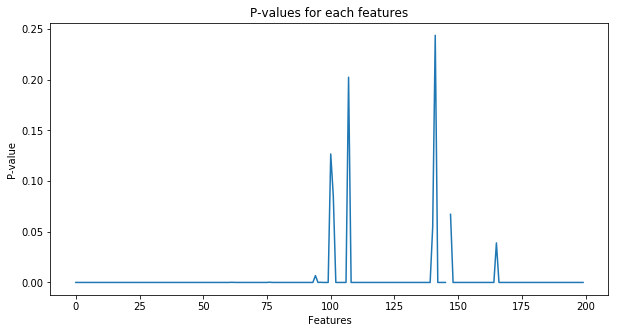

Number of p-values > à 1% : 7


/anaconda3/envs/msbgd/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [31]:
# P-values analysis on features
Kbest = SelectKBest(k="all")
selected_features = Kbest.fit(X_train, y_train)

# Plot P-values
plt.figure(figsize=(10,5))
plt.plot(selected_features.pvalues_)
plt.title("P-values for each features")
plt.xlabel("Features")
plt.ylabel("P-value")
plt.show()

# Display Comment
alpha = 0.01
print("Number of p-values > à 1% : {}".format(np.sum(selected_features.pvalues_ > alpha)))

In [32]:
X_train = X_train[:,np.where(selected_features.pvalues_ < alpha)[0]]
X_test = X_test[:,np.where(selected_features.pvalues_ < alpha)[0]]

/anaconda3/envs/msbgd/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/anaconda3/envs/msbgd/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


### Feature dimension reduction using PCA

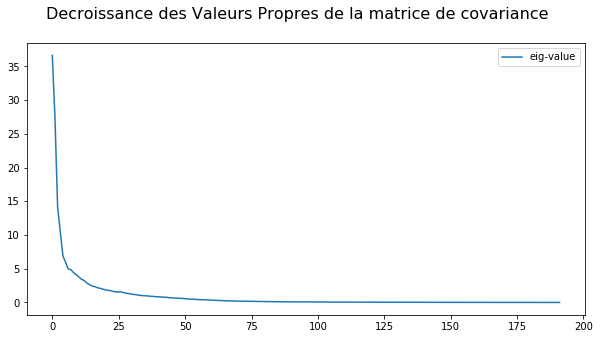

In [33]:
# Covariance matrix
cov = pd.DataFrame(X_train).cov()

# Eigen values of covariance matrix
eig = np.linalg.svd(cov)[1]

# Plot eigen graph
fig = plt.figure(figsize=(10, 5))
fig.suptitle('Decroissance des Valeurs Propres de la matrice de covariance', fontsize = 16)
plt.plot(eig, label = "eig-value")
plt.legend(loc = 'upper right')
plt.show()

In [41]:
# Initialize PCA
pca = PCA(n_components=160)

# Apply PCA on train and test set
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

### Cross-Validation and hyperparameter tuning

In [34]:
# Set C and Gamma parameters list
G_list = [0.001, 0.005, 0.01]
C_list = [1, 2, 3, 4, 5, 7, 10, 20, 50]

# Set the parameters for cross-validation
parameters = [{'kernel': ['rbf'], 'C': C_list, 'gamma': G_list}]

# Initialize SVM model
model = SVC(decision_function_shape='ovr')

# Cross Validation 
cv = GridSearchCV(model, parameters, cv=3, verbose=1, n_jobs=-1).fit(X_train, y_train)

# Print Best parameters
print("Best parameters set found on train set:")
print(cv.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    7.1s finished
/anaconda3/envs/msbgd/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on train set:
{'kernel': 'rbf', 'C': 7, 'gamma': 0.005}


### Best model prediction on test set

In [35]:
# Confusion matrix plot function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Accuracy Score on test dataset: 71.38%


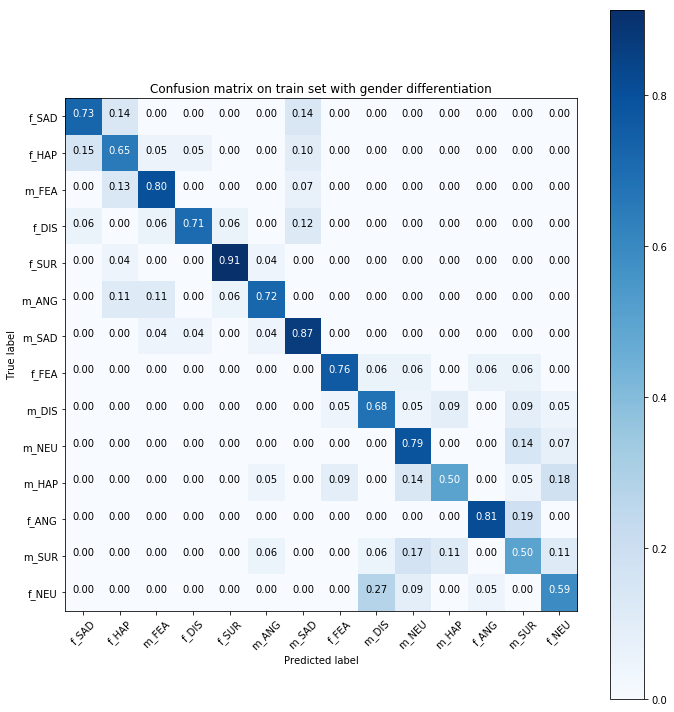

In [42]:
# Fit best mode
model = SVC(kernel='rbf', C=10, gamma=0.005, decision_function_shape='ovr').fit(X_train, y_train)

# Prediction
pred = model.predict(X_test)

# Score
score = model.score(X_test, y_test)

# Reverse label encoder
pred = (lb.inverse_transform((pred.astype(int).flatten())))
actual = (lb.inverse_transform((y_test.astype(int).flatten())))

# Build dataFrame
df_pred = pd.DataFrame({'Actual': actual, 'Prediction': pred})

# Print Score
print('Accuracy Score on test dataset: {}%'.format(np.round(100 * score,2)))

# Compute confusion matrix
confusion = confusion_matrix(actual, pred)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(confusion, classes=set(actual),normalize=True,
                      title='Confusion matrix on train set with gender differentiation')

Accuracy Score on test dataset: 71.75%


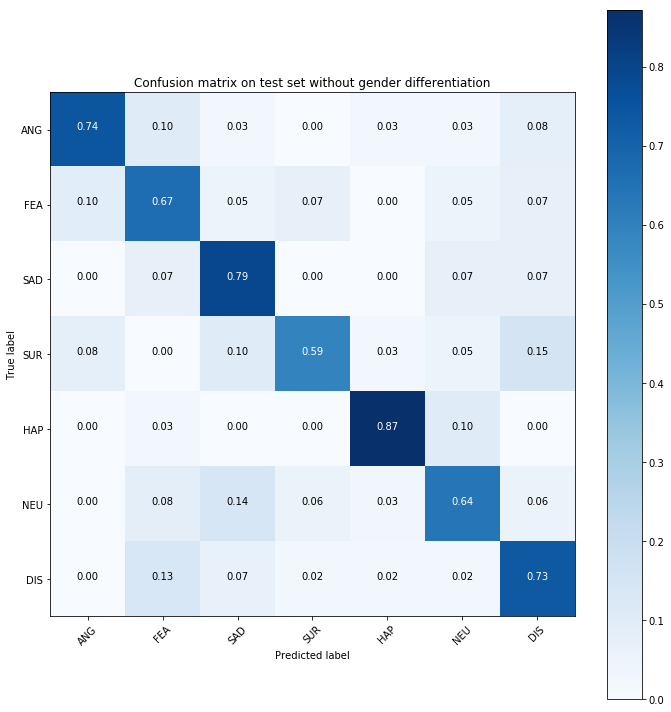

In [43]:
# Compute prediction without gender differentation
PRED = list(map(lambda i:i[2:],pred))
ACTUAL = list(map(lambda i:i[2:],actual))

# Compute related prediction score
SCORE = accuracy_score(ACTUAL, PRED)

# Print Score
print('Accuracy Score on test dataset: {}%'.format(np.round(100 * SCORE,2)))

# Compute confusion matrix
confusion = confusion_matrix(ACTUAL, PRED)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(confusion, classes=set(actual),normalize=True,
                      title='Confusion matrix on test set without gender differentiation')

# Save model

In [ ]:
# save the model to local
pickle.dump(model, open('../Model/MODEL_CLASSIFIER.p', 'wb'))

# Save label encoder
pickle.dump(lb, open("../Model/MODEL_ENCODER.p", "wb"))

# Save PCA
pickle.dump(pca, open("../Model/MODEL_PCA.p", "wb"))

# Save MEAN and STD of each features
MEAN = []
STD = []
for col in df.columns:
    if(col!='label'):
        MEAN.append(df[col].mean())
        STD.append(df[col].std())
pickle.dump([MEAN, STD], open("../Model/MODEL_SCALER.p", "wb"))

# Save feature parameters
stats = ['mean', 'std', 'kurt', 'skew', 'q1', 'q99']
features_list = ['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'sprectral_rolloff']
win_step = 0.01
win_size = 0.025
nb_mfcc = 12
diff = 0
PCA = False
DICO = {'stats':stats, 'features_list':features_list, 'win_size':win_size, 'win_step':win_step, 'nb_mfcc':nb_mfcc, 'diff':diff, 'PCA':False}
pickle.dump(DICO, open("../Model/MODEL_PARAM.p", "wb"))